In [13]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, get_max_distance_to_target_surface, get_average_distance_to_target_surface)
import vis.fields
import matplotlib.cm as cm
import time

In [14]:
import parallelism
parallelism.set_max_num_tbb_threads(24)
parallelism.set_hessian_assembly_num_threads(8)
parallelism.set_gradient_assembly_num_threads(8)

In [15]:
rod_length = 0.09982061776030171
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('bob_quad_1', thickness, width, weaving_dir)
# io = InputOrganizer('bunny_quad_1', thickness, thickness, weaving_dir)

#  [ ear 214, ear 255, nose 39]

0.033273539253433904 0.0023291477477403733


In [4]:
scale_to_ducko = 0.024955154440075428/width

In [5]:
scale_to_ducko

0.75

In [37]:
5 / 0.024955154440075428 / (5 / width)

1.3333333333333333

In [38]:
1/0.75


1.3333333333333333

In [12]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 10
drw = 0.01
dsw = 0.01

### Initialization

In [6]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=False,  width_scale = [1, 1.6], interleaving_type=InterleavingType.weaving)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewer(curved_linkage)
# set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [7]:
curved_linkage.numJoints()

352

In [22]:
surface_curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
# set_surface_view_options(curved_linkage_view)
surface_curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [8]:
# import cross_section_scaling
# importlib.reload(cross_section_scaling)
# width_scale = [0.1, 0.1]
# cross_section = io.RIBBON_CS
# cross_section_scaling.apply_density_based_cross_sections(curved_linkage, elastic_rods.CrossSection.construct('rectangle', 2000, 0.3, [cross_section[0], width_scale[0] * cross_section[1]]), elastic_rods.CrossSection.construct('rectangle', 2000, 0.3, [cross_section[0], width_scale[1] * cross_section[1]]))

In [9]:
E0 = curved_linkage.designParameterSolve_energy()
l0 = curved_linkage.totalRestLength()

In [44]:
bottomColor =[79/255., 158/255., 246/255.]
topColor =[0.5, 0.5, 0.5]
heights = curved_linkage.visualizationGeometryHeightColors()
colors = np.take(np.array([bottomColor, topColor]), heights < heights.mean(), axis=0)

In [45]:
curved_linkage_view.update(scalarField=colors)

In [46]:
curved_linkage_view.setCameraParams(((4.139347366530763, -3.927678946178955, 0.7924706632167623),
 (-0.038125872037145875, 0.15887387844372028, 0.9865624707182293),
 (0.0, 0.0, 0.0)))

In [17]:
curved_linkage.setExtendedDoFsPSRL(np.load("../../../mega_monster_optimization_diagram_results/bob_quad_1/bob_quad_1_stage_2.npy", allow_pickle = True)[-1]['extendedDoFsPSRL'])
# curved_linkage.setExtendedDoFsPSRL(np.load("results/bob_quad_1/bob_quad_1_dof.npy"))

In [10]:
curved_linkage.attraction_weight = 1e-5

In [16]:
curved_linkage.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, [thickness, width * 0.1], stiffAxis=elastic_rods.StiffAxis.D1))
iterateData, dpo = stage_1_optimization(curved_linkage, drw, dsw, curved_linkage_view, E0 = E0, l0 = l0)
curved_linkage.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, [thickness, width * 0.5], stiffAxis=elastic_rods.StiffAxis.D1))
iterateData, dpo = stage_1_optimization(curved_linkage, drw, dsw, curved_linkage_view, E0 = E0, l0 = l0)
curved_linkage.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, [thickness, width], stiffAxis=elastic_rods.StiffAxis.D1))
iterateData, dpo = stage_1_optimization(curved_linkage, drw, dsw, curved_linkage_view, E0 = E0, l0 = l0)

In [17]:
# curved_linkage.scaleJointWeights(0.1, 100, [292, 291, 293, 275, 313, 276, 264, 309, 266, 210, 265, 307, 310, 172, 171, 201])

In [50]:
# jointPos = curved_linkage.jointPositions()
# jointPos = jointPos.reshape((curved_linkage.numJoints(), 3))
# scaled_jointPos = jointPos[np.array([292, 291, 293, 275, 313, 276, 264, 309, 266, 210, 265, 307, 310, 172, 171, 201])]
# with open('{}_feature_joint_pos.obj'.format(io.MODEL_NAME), 'w') as f:
#     for pt in scaled_jointPos:
#         pt *= 100
#         f.write('v {} {} {}\n'.format(pt[0], pt[1], pt[2]))

In [51]:
# curved_linkage.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, [thickness, width], stiffAxis=elastic_rods.StiffAxis.D1))

In [18]:
def eqm_callback(prob, i):
#     curved_linkage_view.update(scalarField=colors)
    pass

In [19]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)

0	5.73321e-05	0.000869817	0.000869817	0.5	0
1	5.48559e-05	0.00509504	0.00509504	1	0
2	5.32873e-05	0.00238176	0.00238176	0.5	0
3	5.30089e-05	0.00418417	0.00418417	0.5	0
4	5.2878e-05	0.00486363	0.00486363	0.5	0
5	5.27821e-05	0.00177893	0.00177893	1	0
6	5.27012e-05	0.000822686	0.000822686	1	0
7	5.26838e-05	0.000504053	0.000504053	1	0
8	5.26807e-05	9.45152e-05	9.45152e-05	1	0
9	5.26804e-05	9.52448e-06	9.52448e-06	1	0
10	5.26804e-05	4.45436e-06	4.45436e-06	1	0
11	5.26804e-05	1.12627e-06	1.12627e-06	0.5	0
12	5.26804e-05	3.35543e-06	3.35543e-06	1	0
13	5.26804e-05	1.34881e-06	1.34881e-06	1	0
14	5.26804e-05	5.6284e-06	5.6284e-06	1	0
15	5.26804e-05	2.94846e-07	2.94846e-07	1	0


In [20]:
curved_linkage_view.update()

In [54]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw)

In [55]:
# optimizer.scaleJointWeights(0.01, 100, [292, 291, 293, 275, 313, 276, 264, 309, 266, 210, 265, 307, 310, 172, 171, 201])

In [56]:
optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, -5, 3)

rl_regularization_weight 1.0
smoothing_weight 10.0
stage 2 optimization with attraction weight 100.0
stage 2 optimization with attraction weight 0.03162277660168379
stage 2 optimization with attraction weight 1e-05


### Validation

In [ ]:
# curved_optimizer_energy = curved_linkage.energy()
# validation_curved_linkage = optimizer.getLinesearchWeaverLinkage()
# validation_curved_linkage.attraction_weight = 1e-7
# with so(): elastic_rods.compute_equilibrium(validation_curved_linkage, options = OPTS, fixedVars = [])
# validation_curved_view = linkage_vis.LinkageViewer(validation_curved_linkage, width=1024, height=640)
# validation_curved_energy = validation_curved_linkage.energy()
# print(abs((validation_curved_energy-curved_optimizer_energy)/curved_optimizer_energy))

In [16]:
# validation_curved_view = linkage_vis.LinkageViewerWithSurface(validation_curved_linkage, io.SURFACE_PATH, width=1024, height=640)
# set_surface_view_options(validation_curved_view)
# validation_curved_view.show()

In [25]:
double_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH, width=1024, height=640)
set_surface_view_options(double_view)
double_view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='white', intensity=0.6, position=(0.0…

In [ ]:
double_view.viewOptions[double_view.ViewType.SURFACE].color

In [17]:
deviation, deviation_vector, joint_normals, joint_projection_normals = get_normal_deviation(curved_linkage)

In [37]:
get_average_distance_to_target_surface(curved_linkage)/io.RIBBON_CS[1]

0.2632755266184439

In [44]:
distance_to_surface = np.array(curved_linkage.get_squared_distance_to_target_surface((curved_linkage.visualizationGeometry()[0]).flatten()))


In [45]:
distance_to_surface = np.sqrt(distance_to_surface)

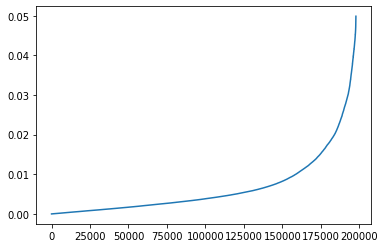

In [54]:
plt.plot(np.sort(distance_to_surface))


In [21]:
set_joint_vector_field(curved_linkage, curved_linkage_view, joint_normals)

In [ ]:
save_path = os.getcwd()
write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME + '_no_feature_joints', io.RIBBON_NAME + '_no_feature_joints', False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False, width = max(io.RIBBON_CS))
os.chdir(save_path)

In [40]:
curved_linkage.numSegments()

618

## Contact Optimization

In [30]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True, interleaving_type=InterleavingType.weaving)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

In [31]:
curved_linkage.setExtendedDoFsPSRL(np.load('results/bob_quad_1/bob_quad_1_dof.npy'))

In [32]:
curved_linkage.attraction_weight = 1e-5

In [33]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [34]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS, fixedVars = [])

0	0.0388859	25.7345	25.7345	1	1
1	0.0326119	39.2816	39.2816	1	1
2	0.0294562	37.2768	37.2768	0.03125	1
3	0.0279567	23.887	23.887	1	1
4	0.0273857	28.2891	28.2891	1	1
5	0.0271523	40.0196	40.0196	1	1
6	0.0270528	60.9224	60.9224	1	1
7	0.0268932	15.565	15.565	1	1
8	0.0268754	4.92176	4.92176	1	1
9	0.0268581	4.30372	4.30372	1	1
10	0.0268242	4.27351	4.27351	1	1
11	0.0267573	4.24554	4.24554	1	1
12	0.026626	4.19978	4.19978	1	1
13	0.026372	4.12378	4.12378	1	1
14	0.0258907	4.00185	4.00185	1	1
15	0.0250057	3.81056	3.81056	1	1
16	0.0234527	3.51549	3.51549	1	1
17	0.0209226	3.08364	3.08364	1	1
18	0.0172515	2.514	2.514	1	1
19	0.0127403	1.86566	1.86566	1	1
20	0.00825513	1.24791	1.24791	1	1
21	0.00474619	0.759735	0.759735	1	1
22	0.00258277	0.4355	0.4355	1	1
23	0.00147589	0.249715	0.249715	1	1
24	0.000941788	0.148407	0.148407	1	1
25	0.000658237	0.0891199	0.0891199	1	1
26	0.000481022	0.053442	0.053442	1	1
27	0.000353198	0.0299932	0.0299932	1	1
28	0.000253485	0.016696	0.016696	1	1
29	0.00017569	0.0198608	0.0

In [36]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw, fixed_boundary_joint = [])

In [37]:
optimizer.setLinkageAttractionWeight(1e-5)

Coefficient of Friction Percentiles 50, 75, 90:  0.5544631096334198 1.0782408003513966 2.602501770203861


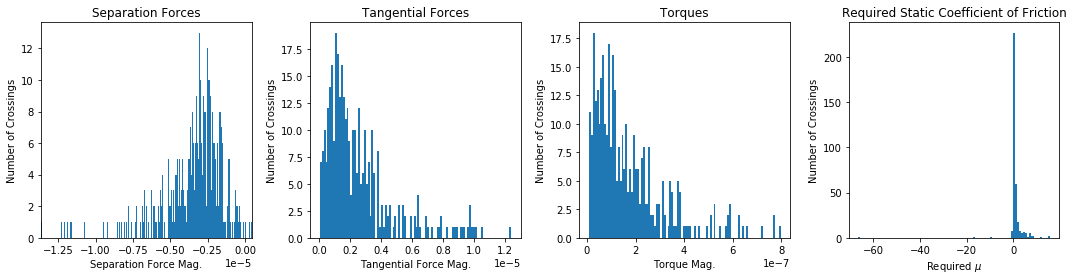

In [16]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [ ]:
contact_optimization(optimizer, curved_linkage_view, -1, 1e4)

Coefficient of Friction Percentiles 50, 75, 90:  2.470886043889795 5.2513449141158866 9.571366017712904


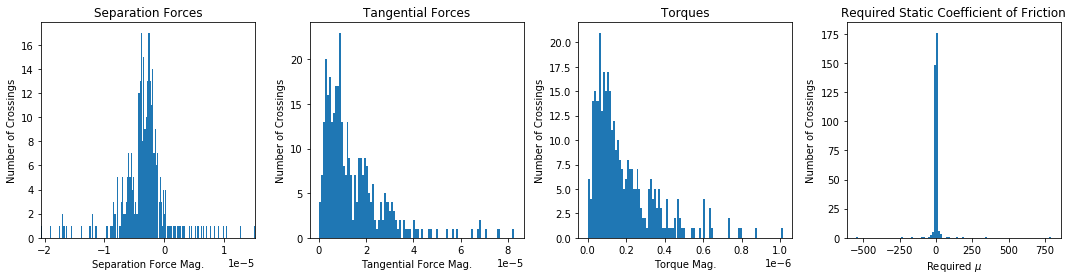

In [21]:
structure_view_2 = get_structure_analysis_view(curved_linkage)
structure_view_2.show()